In [1]:
import math
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from accelerate import Accelerator

from preprocessor import load_and_preprocess, decoding, process_data
from qwen import load_qwen

import numpy as np

import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from transformers import get_cosine_schedule_with_warmup
from preprocessor import get_dataset

import wandb
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/home/ljf1/dis/lora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [2]:
#for matplotlib plots
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
best_overall_params = joblib.load("best_overall_params.joblib")

In [4]:
lora_rank = best_overall_params['lora_rank']
lora_alpha = 2*lora_rank
batch_size = 4
learning_rate = best_overall_params['learning_rate']
test_size = 0.2
max_steps = 1000
max_ctx_length = best_overall_params['max_ctx_length']
points = 80
T_max = max_steps
# warmup_steps = int(0.075*max_steps)
# num_training_steps = max_steps

In [5]:
wandb.init(project="lora_qwen", config={
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "lora_rank": lora_rank,
    "max_steps": max_steps,
    "max_ctx_length": max_ctx_length,
    "test_and_val_size": test_size,
    "T_max": T_max,
    # "warmup_steps": warmup_steps,
    # "num_training_steps": num_training_steps
})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ljustfung (ljustfung-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
def running_mse(prediction, actual):
    mse = []
    for i in range(len(prediction)):
        mse.append(mean_squared_error(prediction[:i+1], actual[:i+1]))
    return mse

def evaluate_model(model, val_loader, step, max_batches=None):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch_idx, (batch,) in enumerate(tqdm(val_loader, desc="val set")):
            # Exit loop after processing max_batches
            if max_batches is not None and batch_idx >= max_batches:
                break
            outputs = model(batch, labels=batch)
            loss = outputs.loss
            total_loss += loss.item()
            
    
    # Calculate metrics - divide by actual number of batches processed
    num_batches = min(len(val_loader), max_batches) if max_batches is not None else len(val_loader)
    avg_loss = total_loss / num_batches

    print(f'Loss on validation subset ({num_batches}/{len(val_loader)} batches) at step {step}: {avg_loss:.4f}')
    return avg_loss

In [ ]:
class LoRALinear(nn.Module):
    def __init__(self, original_linear: nn.Linear, r: int, alpha: int = None):
        super().__init__()
        assert isinstance(original_linear, nn.Linear)
        self.original_linear = original_linear
        self.original_linear.weight.requires_grad = False
        if self.original_linear.bias is not None:
            self.original_linear.bias.requires_grad = False
        in_dim = original_linear.in_features
        out_dim = original_linear.out_features
        self.r = r
        self.alpha = alpha if alpha else r

        device = original_linear.weight.device
        self.A = nn.Parameter(torch.empty(r, in_dim, device=device))
        self.B = nn.Parameter(torch.zeros(out_dim, r, device=device))
        
        # Initialise A with He initialization
        nn.init.kaiming_normal_(self.A, nonlinearity="linear")

    def forward(self, x):
        base_out = self.original_linear(x)
        lora_out = (x @ self.A.T) @ self.B.T
        return base_out + lora_out * (self.alpha / self.r)


model, tokenizer = load_qwen()
tokenizer.padding_side = 'left'

# Actually apply LoRA to the model:
for layer in model.model.layers:
    layer.self_attn.q_proj = LoRALinear(layer.self_attn.q_proj, r=lora_rank, alpha = lora_alpha)
    layer.self_attn.v_proj = LoRALinear(layer.self_attn.v_proj, r=lora_rank, alpha = lora_alpha)
# ^These are the parts that will actually be trained!

for name, param in model.named_parameters():
    if "A" in name or "B" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# Process the data into sequences of text
train_texts, val_texts, test_texts = load_and_preprocess("lotka_volterra_data.h5", test_size=test_size)

# ^Each of these is a `list[str]` representing contiguous parts of the time series,
#  in text form (using the LLMTIME scheme).

In [8]:
# Modified tokenization with chunking
def process_sequences(texts, tokenizer, max_length=512, stride=256):
    all_input_ids = []
    for text in texts:
        # Apply Qwen's tokenization scheme to the text:
        encoding = tokenizer(text, return_tensors="pt", add_special_tokens=False, padding_side='left')
        seq_ids = encoding.input_ids[0]

        # Create sliding windows to further divide the data into chunks:
        for i in range(0, len(seq_ids), stride):
            chunk = seq_ids[i : i + max_length]
            if len(chunk) < max_length:
                chunk = torch.cat(
                    [
                        torch.full((max_length - len(chunk),), tokenizer.pad_token_id),
                        chunk,
                    ]
                )
            all_input_ids.append(chunk)
    return torch.stack(all_input_ids)


def process_data(texts, tokenizer, points=80):
    given_input_ids = []
    for text in texts:
        given_text = ';'.join([chunk for i, chunk in enumerate(text.split(';')) if i < points])
        encoding_given = tokenizer(given_text, return_tensors="pt", padding='max_length', padding_side='left', max_length=1200)
        given_input_ids.append(encoding_given.input_ids[0])
    return np.stack([text for text in texts]), torch.stack(given_input_ids)

# Defines the maximum context length for the model
train_input_ids = process_sequences(
    train_texts, tokenizer, max_ctx_length, stride=max_ctx_length // 2
)
val_input_ids = process_sequences(
    val_texts, tokenizer, max_ctx_length, stride=max_ctx_length
)
test_texts_all, test_input_ids_some = process_data(
    test_texts, tokenizer, points=points
)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=learning_rate
)

# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = CosineAnnealingLR(optimizer, T_max=max_steps)
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_training_steps)

train_dataset = TensorDataset(train_input_ids)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_input_ids)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_input_ids_some)
test_loader = DataLoader(test_dataset, shuffle=False)

# Prepare components with Accelerator
accelerator = Accelerator(mixed_precision='fp16')
model, optimizer, train_loader, scheduler, val_loader = accelerator.prepare(model, optimizer, 
                                                                                         train_loader, 
                                                                                         scheduler, 
                                                                                         val_loader
                                                                                         )

In [9]:
# Train the model
steps = 0
train_losses = []
val_losses = []
while steps < max_steps:
    progress_bar = tqdm(train_loader, desc=f"Steps {steps}")
    for (batch,) in progress_bar:
        model.train()
        optimizer.zero_grad()
        outputs = model(batch, labels=batch)
        loss = outputs.loss
        train_losses.append([loss.item(), steps])
        accelerator.backward(loss)
        optimizer.step()
        scheduler.step()
        steps += 1

        progress_bar.set_postfix(loss=loss.item())

        wandb.log({
            "train_loss": loss.item(),
            "steps": steps,
            "lr": optimizer.param_groups[0]['lr'],
            })

        if (steps % 50) == 0:
            avg_loss = evaluate_model(model, val_loader, steps)
            val_losses.append([avg_loss, steps])
            model.eval()

            wandb.log({
            "val_loss": avg_loss,
            "steps": steps,
            })

        if steps > max_steps:
            break    

Steps 0:   6%|▋         | 50/800 [09:24<9:50:01, 47.20s/it, loss=0.606]

Loss on validation subset (50/50 batches) at step 50: 0.7645


Steps 0:  12%|█▎        | 100/800 [17:38<8:55:41, 45.92s/it, loss=0.481]

Loss on validation subset (50/50 batches) at step 100: 0.7031


Steps 0:  19%|█▉        | 150/800 [25:59<8:39:54, 47.99s/it, loss=0.668]

Loss on validation subset (50/50 batches) at step 150: 0.6732


Steps 0:  25%|██▌       | 200/800 [34:11<7:24:43, 44.47s/it, loss=0.734]

Loss on validation subset (50/50 batches) at step 200: 0.6552


Steps 0:  31%|███▏      | 250/800 [42:25<7:06:33, 46.53s/it, loss=0.176]

Loss on validation subset (50/50 batches) at step 250: 0.6439


Steps 0:  38%|███▊      | 300/800 [50:31<6:13:04, 44.77s/it, loss=0.363]

Loss on validation subset (50/50 batches) at step 300: 0.6325


Steps 0:  44%|████▍     | 350/800 [58:15<5:24:49, 43.31s/it, loss=0.596]

Loss on validation subset (50/50 batches) at step 350: 0.6239


Steps 0:  50%|█████     | 400/800 [1:06:40<5:05:50, 45.88s/it, loss=0.505]

Loss on validation subset (50/50 batches) at step 400: 0.6164


Steps 0:  56%|█████▋    | 450/800 [1:14:53<4:30:59, 46.46s/it, loss=0.453]

Loss on validation subset (50/50 batches) at step 450: 0.6103


Steps 0:  62%|██████▎   | 500/800 [1:23:01<3:50:20, 46.07s/it, loss=0.449]

Loss on validation subset (50/50 batches) at step 500: 0.6055


Steps 0:  69%|██████▉   | 550/800 [1:31:10<3:10:01, 45.60s/it, loss=0.521]

Loss on validation subset (50/50 batches) at step 550: 0.6026


Steps 0:  75%|███████▌  | 600/800 [1:39:23<2:34:30, 46.35s/it, loss=0.612]

Loss on validation subset (50/50 batches) at step 600: 0.6002


Steps 0:  81%|████████▏ | 650/800 [1:47:33<1:55:38, 46.26s/it, loss=0.157]

Loss on validation subset (50/50 batches) at step 650: 0.5950


Steps 0:  88%|████████▊ | 700/800 [1:55:18<1:12:17, 43.38s/it, loss=0.583]

Loss on validation subset (50/50 batches) at step 700: 0.5940


Steps 0:  94%|█████████▍| 750/800 [2:03:42<38:13, 45.87s/it, loss=0.456]

Loss on validation subset (50/50 batches) at step 750: 0.5918


Steps 0: 100%|██████████| 800/800 [2:11:34<00:00,  9.87s/it, loss=0.521]


Loss on validation subset (50/50 batches) at step 800: 0.5898


Steps 800:   6%|▋         | 50/800 [07:12<8:21:02, 40.08s/it, loss=0.689]

Loss on validation subset (50/50 batches) at step 850: 0.5892


Steps 800:  12%|█▎        | 100/800 [14:29<7:36:56, 39.17s/it, loss=0.351]

Loss on validation subset (50/50 batches) at step 900: 0.5891


Steps 800:  19%|█▉        | 150/800 [21:12<6:48:23, 37.70s/it, loss=0.504]

Loss on validation subset (50/50 batches) at step 950: 0.5886


Steps 800:  25%|██▌       | 200/800 [27:54<6:12:26, 37.24s/it, loss=0.096]

Loss on validation subset (50/50 batches) at step 1000: 0.5885


Steps 800:  25%|██▌       | 200/800 [28:00<1:24:00,  8.40s/it, loss=0.541]


In [ ]:
# Unwrap model from accelerator
unwrapped_model = accelerator.unwrap_model(model)

# Create a dictionary to store LoRA weights
lora_state_dict = {}

# Extract LoRA weights from each layer
for i, layer in enumerate(unwrapped_model.model.layers):
    # Save Q projection LoRA weights
    if hasattr(layer.self_attn.q_proj, 'A'):
        lora_state_dict[f'layer_{i}.self_attn.q_proj.A'] = layer.self_attn.q_proj.A.detach().cpu()
        lora_state_dict[f'layer_{i}.self_attn.q_proj.B'] = layer.self_attn.q_proj.B.detach().cpu()
    
    # Save V projection LoRA weights
    if hasattr(layer.self_attn.v_proj, 'A'):
        lora_state_dict[f'layer_{i}.self_attn.v_proj.A'] = layer.self_attn.v_proj.A.detach().cpu()
        lora_state_dict[f'layer_{i}.self_attn.v_proj.B'] = layer.self_attn.v_proj.B.detach().cpu()

# Save metadata
lora_state_dict['config'] = {
    'lora_rank': lora_rank,
    'lora_alpha': lora_alpha,
    'max_ctx_length': max_ctx_length
}

# Save to file
torch.save(lora_state_dict, f"../models/{wandb.run.name}_lora_weights.pt")
torch.save(optimizer.state_dict(), f"../models/{wandb.run.name}_optimizer_state.pth")
torch.save(scheduler.state_dict(), f"../models/{wandb.run.name}_scheduler_state.pth")

LoRA weights saved to ../models/trim-glade-27_lora_weights.pt


In [ ]:
# # Load the saved LoRA weights
# saved_model_path = f"../models/{wandb.run.name}_lora_weights.pt"
# lora_state_dict = torch.load(saved_model_path)
# print(f"Loading LoRA weights from {saved_model_path}")

# # Extract configuration
# loaded_config = lora_state_dict.get('config', {})
# print(f"Loaded model config: {loaded_config}")

# # Load weights into model
# unwrapped_model = accelerator.unwrap_model(model)
# for i, layer in enumerate(unwrapped_model.model.layers):
#     # Load Q projection LoRA weights
#     if f'layer_{i}.self_attn.q_proj.A' in lora_state_dict:
#         layer.self_attn.q_proj.A.data = lora_state_dict[f'layer_{i}.self_attn.q_proj.A'].to(layer.self_attn.q_proj.A.device)
#         layer.self_attn.q_proj.B.data = lora_state_dict[f'layer_{i}.self_attn.q_proj.B'].to(layer.self_attn.q_proj.B.device)
    
#     # Load V projection LoRA weights
#     if f'layer_{i}.self_attn.v_proj.A' in lora_state_dict:
#         layer.self_attn.v_proj.A.data = lora_state_dict[f'layer_{i}.self_attn.v_proj.A'].to(layer.self_attn.v_proj.A.device)
#         layer.self_attn.v_proj.B.data = lora_state_dict[f'layer_{i}.self_attn.v_proj.B'].to(layer.self_attn.v_proj.B.device)

# print("LoRA weights loaded successfully")

In [13]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

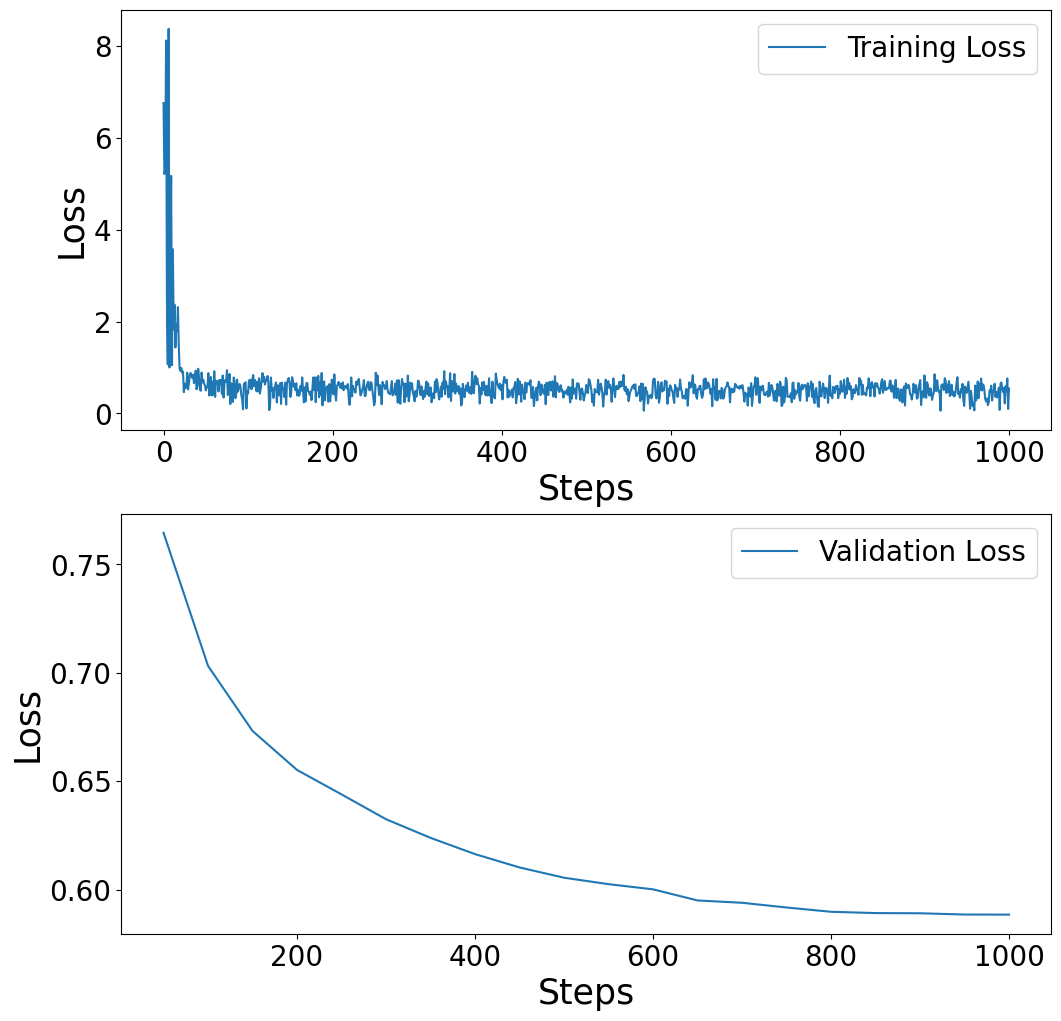

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(train_losses[:, 1], train_losses[:, 0], label="Training Loss")
ax[1].plot(val_losses[:, 1], val_losses[:, 0], label="Validation Loss")
ax[0].set_xlabel("Steps")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].set_xlabel("Steps")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.savefig(f"../plots/{wandb.run.name}_loss.png")
plt.show()

In [16]:
model.eval

<bound method Module.eval of Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=896, bias=True)
          )
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): LoRALinear(
            (original_linear): Linear(in_features=896, out_features=128, bias=True)
          )
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attent

In [ ]:
torch.cuda.empty_cache()

In [42]:
accelerator = Accelerator()
model, test_loader = accelerator.prepare(model, test_loader)

In [43]:
model.eval()
with torch.no_grad():    
    for (batch,) in tqdm(test_loader):
        outputs = model.generate(batch, attention_mask = torch.ones_like(batch), max_new_tokens=max_ctx_length*2)
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        prediction_decoded = decoding(prediction)
        break

test_decoded = decoding(test_texts_all[0])

  0%|          | 0/100 [01:10<?, ?it/s]


In [44]:
import h5py
with h5py.File("lotka_volterra_data.h5", "r") as f:
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]
    prey = trajectories[:, :, 0]
    predator = trajectories[:, :, 1]
    times = time_points[:]
    
def scaler(prey, predator, alpha, decimals=3):
    prey = np.array(prey)
    predator = np.array(predator)
    data = np.stack([prey, predator], axis=-1)
    rescaled = data/alpha * 10
    return np.round(rescaled, decimals = decimals)

def encoding(prey, predator):
    series = np.column_stack((prey, predator))
    encoded = ';'.join([','.join(map(str, row)) for row in series])
    return encoded

dataset = scaler(prey, predator, 5)
encoded = [encoding(prey, predator) for prey, predator in zip(dataset[:,0], dataset[:,1])]

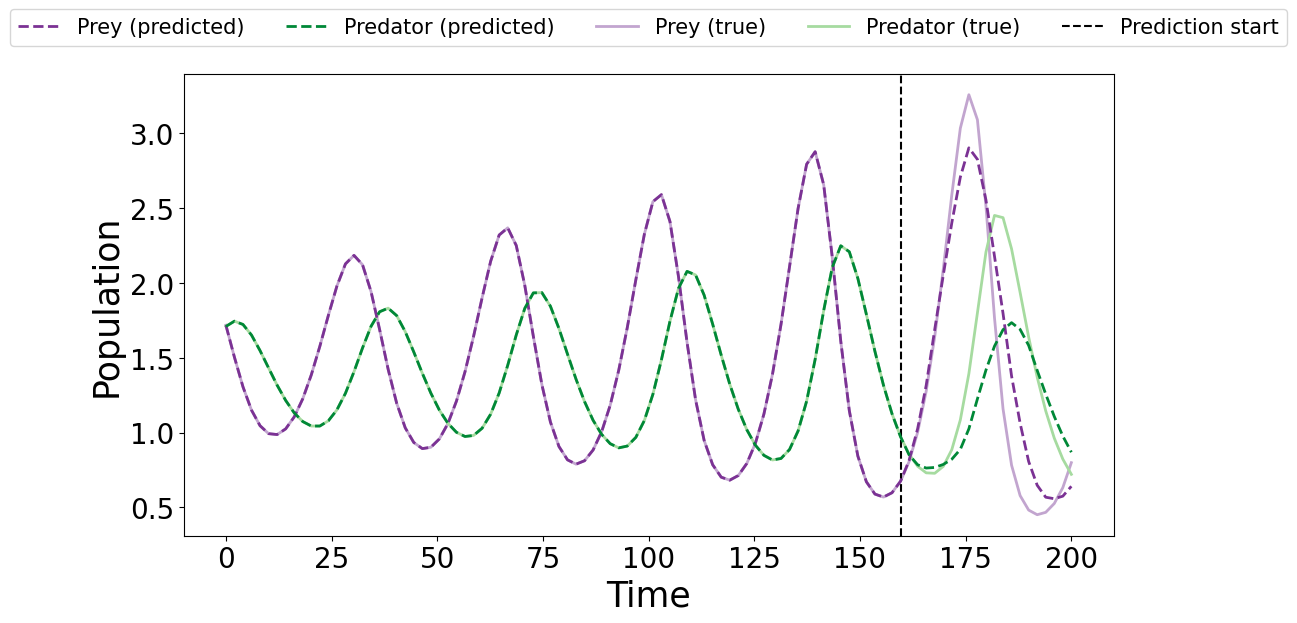

In [45]:
colours = ['#7b3294', '#c2a5cf', '#a6dba0', '#008837']
_, _, time = get_dataset()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time, prediction_decoded[0], label='Prey (predicted)', linestyle="--", zorder=100, color=colours[0], linewidth=2)
ax.plot(time, prediction_decoded[1], label='Predator (predicted)', linestyle="--", zorder=100, color=colours[3], linewidth=2)
ax.plot(time, test_decoded[0], label='Prey (true)', color=colours[1], linewidth=2)
ax.plot(time, test_decoded[1], label='Predator (true)', color=colours[2], linewidth=2)
ax.axvline(time[79], color='black', linestyle='--', label='Prediction start')
ax.set_xlabel('Time')
ax.set_ylabel('Population')
ax.legend(fontsize=15, ncol=5, bbox_to_anchor=(0.5, 1.1), loc='center')
plt.savefig(f'../plots/{wandb.run.name}_inspection.png')
plt.show()


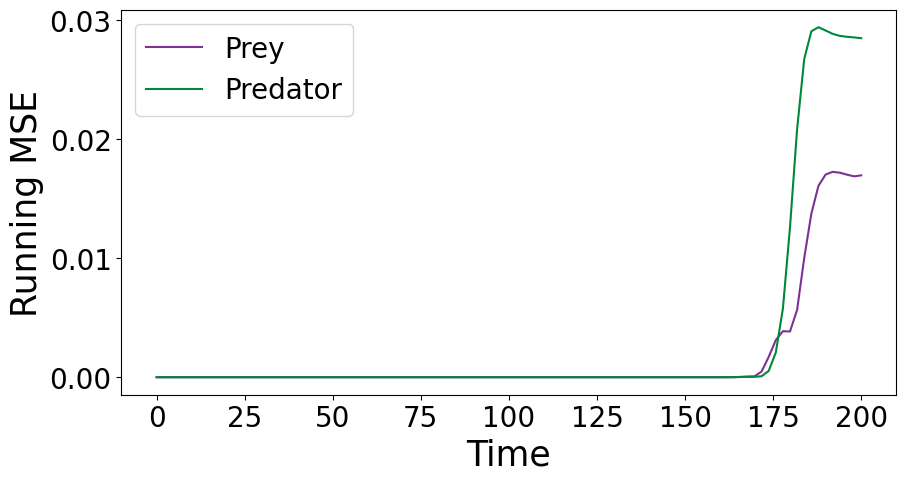

In [46]:
running_mse_prey = running_mse(prediction_decoded[0], test_decoded[0])
running_mse_predator = running_mse(prediction_decoded[1], test_decoded[1])
fig, ax = plt.subplots(figsize=(10, 5))
# ax.set_title(f"Running MSE")
ax.plot(times, running_mse_prey, label="Prey", color=colours[0])
ax.plot(times, running_mse_predator, label="Predator", color=colours[3])
ax.set_xlabel("Time")
ax.set_ylabel("Running MSE")
ax.legend()
plt.savefig(f"../plots/{wandb.run.name}_running_mse.png")
plt.show()

In [ ]:
pred_prey = prediction_decoded[0]
pred_predator = prediction_decoded[1]
actual_prey = test_decoded[0]
actual_predator = test_decoded[1]

mean_prey_squared_error = mean_squared_error(pred_prey, actual_prey)
mean_prey_absolute_error = mean_absolute_error(pred_prey, actual_prey)
r2_prey_score = r2_score(pred_prey, actual_prey)
mean_predator_squared_error = mean_squared_error(pred_predator, actual_predator)
mean_predator_absolute_error = mean_absolute_error(pred_predator, actual_predator)
r2_predator_score = r2_score(pred_predator, actual_predator)

print("MEAN PREY SQUARED ERROR:", mean_prey_squared_error)
print("MEAN PREY ABSOLUTE ERROR:", mean_prey_absolute_error)
print("R2 PREY SCORE:", r2_prey_score)
print("MEAN PREDATOR SQUARED ERROR:", mean_predator_squared_error)
print("MEAN PREDATOR ABSOLUTE ERROR:", mean_predator_absolute_error)
print("R2 PREDATOR SCORE:", r2_predator_score)

joblib.dump({
    "mean_prey_squared_error": mean_prey_squared_error,
    "mean_prey_absolute_error": mean_prey_absolute_error,
    "r2_prey_score": r2_prey_score,
    "mean_predator_squared_error": mean_predator_squared_error,
    "mean_predator_absolute_error": mean_predator_absolute_error,
    "r2_predator_score": r2_predator_score,
    "running_mse_prey": running_mse_prey,
    "running_mse_predator": running_mse_predator,
    "train_losses": train_losses,
    "val_losses": val_losses
}, f"../results/{wandb.run.name}.pkl")

MEAN PREY SQUARED ERROR: 0.016959469999999997
MEAN PREY ABSOLUTE ERROR: 0.04333
R2 PREY SCORE: 0.9610798690254714
MEAN PREDATOR SQUARED ERROR: 0.028483359999999992
MEAN PREDATOR ABSOLUTE ERROR: 0.051160000000000004
R2 PREDATOR SCORE: 0.8102771653190336


['../results/trim-glade-27.pkl']

: 